In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga de datos
# Asegúrate de subir el archivo 'dataset_ia_log_returns_10y.csv' a la carpeta de Colab
url = 'dataset_ia_log_returns_10y.csv'
df = pd.read_csv(url, index_col=0, parse_dates=True)

print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
df.head()

Dataset cargado con éxito. Dimensiones: (2511, 12)


,JPM,ETN,NVDA,NEE,V,AMZN,MSFT,PGR,XOM,WELL,PG,WMT
2016-02-05,-0.011192,0.005504,-0.065177,0.000793,-0.029474,-0.065760,-0.036026,0.001304,0.003127,0.004605,0.006177,0.008694
2016-02-08,-0.021175,0.008199,-0.046862,0.004917,-0.054137,-0.028339,-0.015065,0.000977,0.013396,-0.041073,0.017337,-0.001493
2016-02-09,-0.006032,-0.011497,0.010649,0.010282,0.008229,-0.012431,-0.002635,0.004869,-0.004361,-0.083267,0.000242,-0.016427
2016-02-10,-0.012173,-0.014420,-0.002357,-0.014056,0.026287,0.017295,0.008688,0.000971,-0.009157,-0.000538,-0.012419,-0.000304
2016-02-11,-0.045131,-0.011236,-0.005125,-0.016309,-0.024240,0.026835,-0.000403,-0.022245,0.003146,-0.037119,-0.021299,-0.007170


--- RESUMEN ESTADÍSTICO ---


,JPM,ETN,NVDA,NEE,V,AMZN,MSFT,PGR,XOM,WELL,PG,WMT
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,0.000766,0.000833,0.002241,0.000552,0.000615,0.000872,0.000894,0.000873,0.000402,0.000584,0.000360,0.000743
std,0.017307,0.018487,0.031185,0.015904,0.015345,0.020433,0.016905,0.015318,0.017483,0.020227,0.011803,0.013513
min,-0.162106,-0.169183,-0.207712,-0.144068,-0.145571,-0.151398,-0.159453,-0.140618,-0.130391,-0.279654,-0.091428,-0.120764
25%,-0.006990,-0.007357,-0.012974,-0.006621,-0.006169,-0.008795,-0.006626,-0.006647,-0.008023,-0.007777,-0.005127,-0.005390
50%,0.000768,0.001094,0.002797,0.001212,0.001422,0.001179,0.001069,0.001093,0.000513,0.001520,0.000669,0.000836
75%,0.008901,0.009922,0.018470,0.008261,0.008135,0.011454,0.009651,0.008491,0.009215,0.009337,0.006338,0.007104
max,0.165620,0.209164,0.260877,0.128309,0.129647,0.126949,0.132929,0.114554,0.119442,0.208467,0.113409,0.110723
skew,-0.075218,-0.197693,0.092929,-0.534458,-0.157351,-0.016967,-0.262437,-0.464795,-0.229012,-0.934068,-0.082529,0.083416
kurtosis,13.574427,14.304455,6.707561,9.719157,10.211549,5.192260,8.344677,9.079015,6.688713,33.133549,11.133770,14.658640


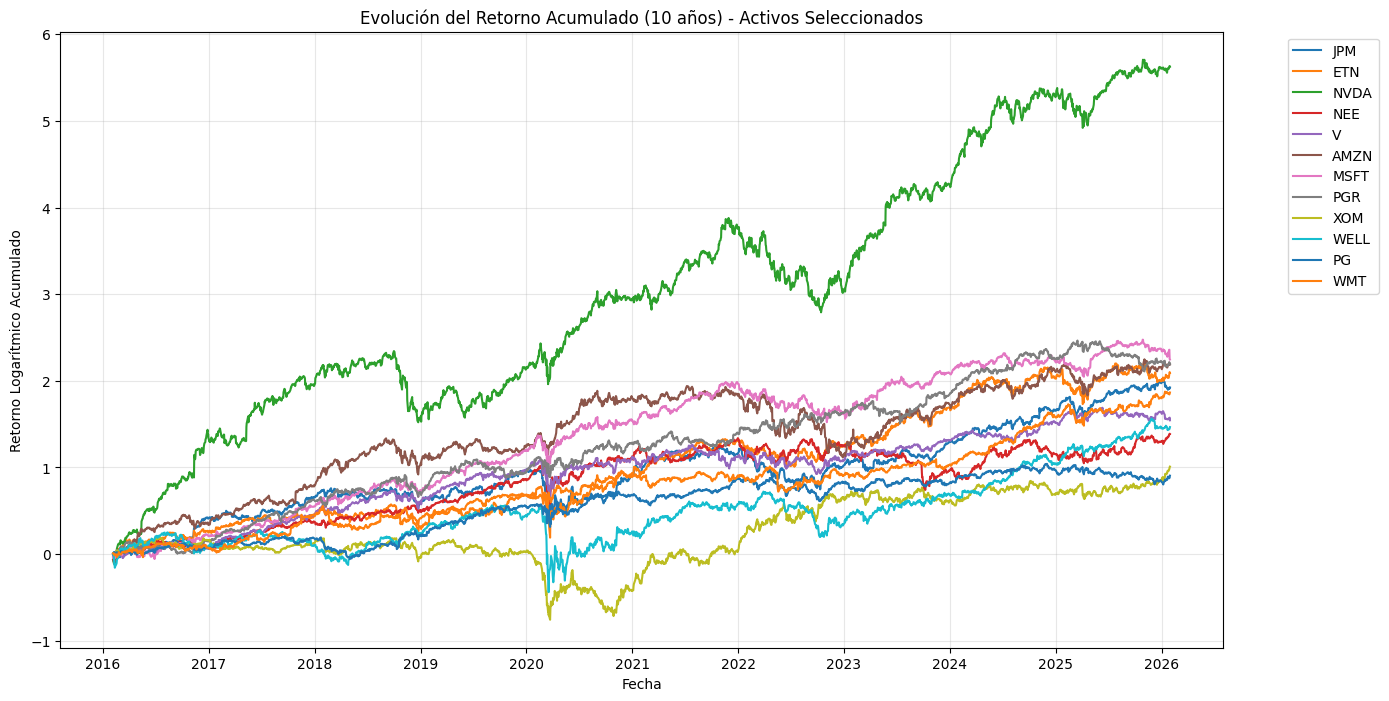

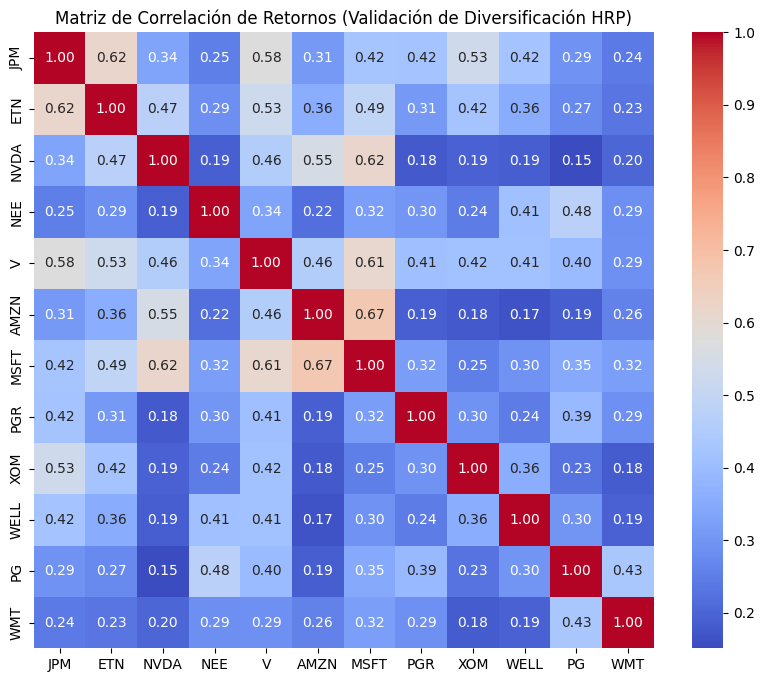

In [2]:
# --- EDA: Estadísticas Descriptivas ---
print("--- RESUMEN ESTADÍSTICO ---")
stats = df.describe()
# Añadimos curtosis y skewness (clave en finanzas: colas gordas)
stats.loc['skew'] = df.skew()
stats.loc['kurtosis'] = df.kurtosis()
display(stats)

# --- EDA: Visualización de Series Temporales ---
plt.figure(figsize=(15, 8))
for column in df.columns:
    plt.plot(df.index, df[column].cumsum(), label=column) # Retorno acumulado para ver la tendencia

plt.title('Evolución del Retorno Acumulado (10 años) - Activos Seleccionados')
plt.xlabel('Fecha')
plt.ylabel('Retorno Logarítmico Acumulado')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# --- EDA: Matriz de Correlación ---
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Retornos (Validación de Diversificación HRP)')
plt.show()

In [3]:
# --- PREPARACIÓN PARA APRENDIZAJE SUPERVISADO ---

# Queremos predecir el futuro inmediato (t+1)
# X será el dataframe desde el inicio hasta el penúltimo día
# y será el dataframe desde el segundo día hasta el final (desplazado 1 día)

X = df.iloc[:-1].values # Entradas (t)
y = df.iloc[1:].values  # Salidas (t+1)

print("Estructura de las variables para el modelo:")
print(f"Forma de X (Inputs): {X.shape}")
print(f"Forma de y (Targets): {y.shape}")

# Ejemplo de la primera fila
print("\nEjemplo de ejecución (Primer paso de tiempo):")
print(f"Si X[0] es: {X[0][:3]}... (primeros 3 activos)")
print(f"Entonces y[0] debe ser el retorno del día siguiente: {y[0][:3]}...")

Estructura de las variables para el modelo:
Forma de X (Inputs): (2510, 12)
Forma de y (Targets): (2510, 12)

Ejemplo de ejecución (Primer paso de tiempo):
Si X[0] es: [-0.01119243  0.00550373 -0.06517678]... (primeros 3 activos)
Entonces y[0] debe ser el retorno del día siguiente: [-0.02117495  0.00819883 -0.04686223]...
